In [1]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

warnings.filterwarnings("ignore")

In [2]:
os.listdir('./data/')

['Illumina', 'Patagonic']

In [5]:
train_audio_path = './data/'
samples, sample_rate = librosa.load(train_audio_path+'Illumina/data (1).wav', sr = 16000)
# fig = plt.figure(figsize=(14, 8))
# ax1 = fig.add_subplot(211)
# ax1.set_title('Raw wave of ' + '../input/train/audio/yes/0a7c2a8d_nohash_0.wav')
# ax1.set_xlabel('time')
# ax1.set_ylabel('Amplitude')
# samples, sample_rate
# ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)
samples, sample_rate

(array([ 0.        ,  0.        ,  0.        , ..., -0.0012207 ,
        -0.00152588, -0.00112915], dtype=float32),
 16000)

In [6]:
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)
np.array(samples, dtype='float64')

16000


array([ 0.        ,  0.        ,  0.        , ..., -0.0012207 ,
       -0.00152588, -0.00112915])

In [7]:
samples=np.array(samples, dtype='float64')
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

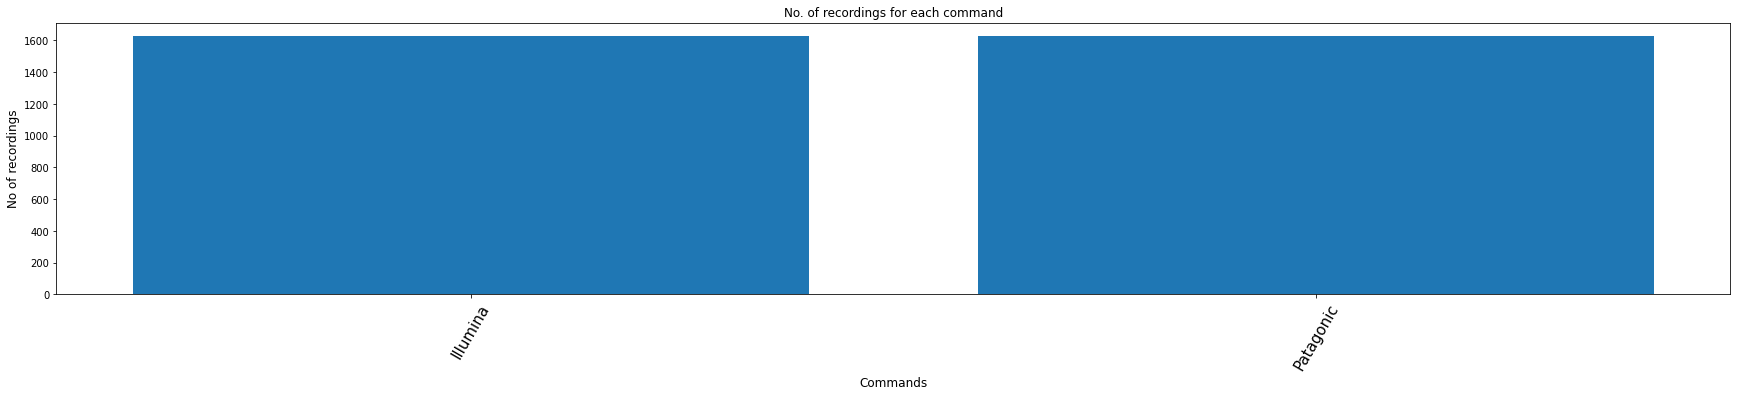

In [9]:
labels=os.listdir(train_audio_path)

#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

labels=["Illumina", "Patagonic"]

(array([  16.,  272.,  752., 1072.,  496.,  205.,  336.,   64.,   32.,
          16.]),
 array([0.8 , 0.93, 1.06, 1.19, 1.32, 1.45, 1.58, 1.71, 1.84, 1.97, 2.1 ]),
 <BarContainer object of 10 artists>)

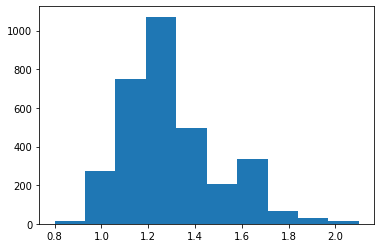

In [10]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [292]:
train_audio_path = './data/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

Illumina
Patagonic


In [298]:
train_audio_path = 'train/audio/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

In [299]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

In [300]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [301]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.1,random_state=777,shuffle=True)

ValueError: With n_samples=1, test_size=0.1 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [276]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#LSTM
conv = LSTM(64,return_sequences=True)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.2)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.2)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 2662, 64)          18688     
_________________________________________________________________
flatten (Flatten)            (None, 170368)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                109036

In [277]:
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [278]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.00001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [279]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/100
1/1 [==============================] - 25s 25s/step - loss: 0.6930 - accuracy: 0.5000 - val_loss: 0.6640 - val_accuracy: 1.0000
Epoch 2/100
1/1 [==============================] - 25s 25s/step - loss: 0.6628 - accuracy: 1.0000 - val_loss: 0.6369 - val_accuracy: 1.0000
Epoch 3/100
1/1 [==============================] - 25s 25s/step - loss: 0.6317 - accuracy: 1.0000 - val_loss: 0.6039 - val_accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 22s 22s/step - loss: 0.5949 - accuracy: 1.0000 - val_loss: 0.5604 - val_accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 22s 22s/step - loss: 0.5530 - accuracy: 1.0000 - val_loss: 0.5038 - val_accuracy: 1.0000
Epoch 6/100
1/1 [==============================] - 24s 24s/step - loss: 0.5001 - accuracy: 1.0000 - val_loss: 0.4296 - val_accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 22s 22s/step - loss: 0.4309 - accuracy: 1.0000 - val_loss: 0.3438 - val_accuracy: 1.0000
Epoch 8/100
1/1 [===

KeyboardInterrupt: 

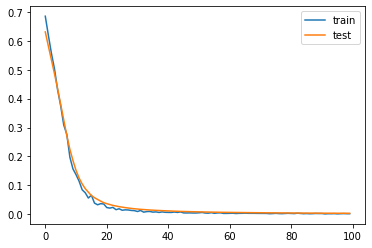

In [280]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [281]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [283]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))

Audio: Illumina
Text: Illumina


In [7]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 2 # seconds
filename = '2.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


In [284]:
os.listdir('./')
filepath='./'

#reading the voice commands
samples, sample_rate = librosa.load(filepath + '/' + 'yes.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)

predict(samples)

'Illumina'